<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H2/Simulation%20-%20Mateo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1
The first part of this assignment consists in studying a single particule performing a continuous-time random walk in the network described by the graph in Fig. 1 and with the following transition rate matrix:

$\Lambda =
\begin{pmatrix}
0 & \frac{2}{5} & \frac{1}{5} & 0 & 0 \\
0 & 0 & \frac{3}{4} & \frac{1}{4} & 0 \\
\frac{1}{2} & 0 & 0 & \frac{1}{3} & 0 \\
0 & 0 & \frac{1}{3} & 0 & \frac{2}{3} \\
0 & \frac{1}{2} & 0 & \frac{1}{3} & 0
\end{pmatrix}
$
<figure>
    <img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H2/sources/G.png"/>
    <figcaption>Figure 1: Closed network in which particles move according to the transition rate matrix (1)</figcaption>
</figure>
Your task is to simulate the particle moving around in the network in continuous time according to the transition rate matrix (1).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from numpy.random import choice, rand
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}
import progressbar
import time

### Definition of the graph

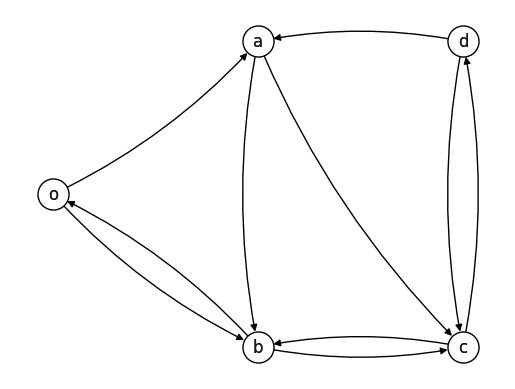

In [2]:
#defining and printing the give graph
V = ['o', 'a', 'b', 'c', 'd']
E = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('b','c'), ('b','o'),
         ('c','b'), ('c','d'), ('d','a'), ('d','c')]

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

### Continuous Random-walk
We will use the first approach of the three ways we saw in class of modelling Continuous-Time Markov Chains which is described as follows

**1st approach**
1. you define a unique **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when you are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $\bar P_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or you stay in the same node (no transition) with probability $\bar P_{ii} = 1 - \sum_{i \neq j} \bar P_{ij}$.

In this approach, the continuous time is discretized using a global clock, while the matrix Q describes the jumps. For this reason the matrix $\bar P$ is called **jump chain** of the CTMC.

Notice that $\bar P_{ii}=0$ for the nodes $i$ maximizing $\omega$, and it is larger as $\omega_i/\omega$ is small.

**Function to simulate a Continuos random walk**

* `P_bar` = The $\bar{P}$ matrix of the graph
* `x_0`, `x_n` = Node to start and to end the walk
* `n_steps` = Number of jump to do considered only if `end_node` is `None` and `n_steps != -1` (If `x_n == None` and `n_steps <= 0` the random walk stops the first time it returns to the starting node `x_0`)

In [3]:
def compute_P_bar(Lambda):
    # Defining w for the clock in continuos time
    w = np.sum(Lambda, axis=1)
    w_star = np.max(w)

    # Defining P_bar (we are in continuos time)
    P_bar = Lambda/w_star
    P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

    return P_bar, w_star

In [4]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def ContinuousTimeRandomWalk(Lambda, x_0, x_n = None, n_steps=-1):
    till_x_0_return = n_steps <= 0 and x_n is None

    P_bar, w_star = compute_P_bar(Lambda)
    n_states = len(P_bar)

    # walk stores the sequence of visited nodes
    walk = [x_0]

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]

    current_pos = 1

    # No upper bound on the number of steps
    while current_pos != n_steps + 1:
        # The random time to wait for the next transition
        # is drawn according to its distribution, as discussed in Remark 1
        # NOTE: in the formula for t_next we use w_star, the rate of the "global" Poisson clock
        t_next = np.random.exponential(1/w_star)

        # The next state to visit will be extracted according to the probabilities
        # stored in the row of P_bar corresponding to the current state.
        # We extract a value pos[i] in (0,...,num_states-1) according to the discrete distribution P_bar[pos[i-1],:]
        walk.append(np.random.choice(n_states, p=P_bar[walk[current_pos-1],:]))
        transition_times.append(transition_times[current_pos-1] + t_next)

        # Check if the walk has returned to the starting node
        # or the walk arrived to the end node
        # if so, end the walk
        if walk[current_pos] == x_0 and till_x_0_return or walk[current_pos] == x_n:
            return walk, transition_times

        current_pos += 1

    return walk, transition_times

In [5]:
def SingleParticleSimulations(Lambda, start_node, n_simulations, end_node = None, n_steps = -1, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(ContinuousTimeRandomWalk(Lambda, start_node, end_node, n_steps))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

## Point a
What is, according to the simulations, the average time it takes a particle that starts in node $a$ to leave the node and then return to it?


In [6]:
# Defining Lambda
Lambda = np.array([
     [0, 2/5, 1/5, 0, 0],
     [0, 0, 3/4, 1/4, 0],
     [1/2, 0, 0, 1/3, 0],
     [0, 0, 1/3, 0, 2/3],
     [0, 1/2, 0, 1/3, 0]
])

# Defining P_bar (we are in continuous time)
P_bar, _ = compute_P_bar(Lambda)

# Compute pi_bar the invariant probability vector by determining the leading eigenvector of the matrix P_bar′
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


Simulations

In [7]:
start_node = V.index('a')

In [ ]:
results_simulation = SingleParticleSimulations(Lambda, start_node, 10000)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:03 Time:  0:00:03


In [ ]:
times = [simulation[1][-1] for simulation in results_simulation]
print("Empirical average time to return in a starting from a:", np.mean(times))

Empirical average time to return in a starting from a: 6.055986426243066


## Point b
How does the result in a) compare to the theoretical return-time $\mathbb{E}_{a}\left ( T^{+}_{a}  \right )$? (Include a description of how this is computed)

**Solution**
The theoretical return time $\mathbb{E}_{a}\left ( T^{+}_{a}  \right )$ is given by the formula: $$\mathbb{E}_{a}\left ( T^{+}_{a}  \right )=\frac{1}{\omega_{a}\bar{\pi}_{a}}$$ where $\omega_{a}$ and $\bar{\pi}_{a}$ are previously computed values.

The value of $\omega_{a}$ is given by:
$$w_{a}=\sum_{j}\Lambda_{aj}=3/4+1/4=1$$
The stationary probability $\bar{\pi}_{a}$ corresponds to the value associated with node $a$ in the stationary probability vector of $\bar{P}'$, where $\bar{P}'$ is defined as:

$\bar{P}_{ij}=\frac{\Lambda_{ij}}{w_{*}}$, for $i\neq j$

$\bar{P}_{ii}=1-\sum_{j\neq i}\bar{P}_{ij}$

The computed stationary probability vector $\bar{\pi}$ is:
$$\bar{\pi}=\begin{pmatrix}
0.23058252 & 0.16504854 & 0.27669903 & 0.18203883 & 0.14563107  \\
\end{pmatrix}'$$
Thus, the theoretical return time for node $a$ is:
$$\mathbb{E}_{a}\left ( T^{+}_{a}  \right )\approx\frac{1}{1\times0.16504854}\approx6.058823529411766$$

In [ ]:
1 / pi_bar[V.index('a')]

6.058823529411766

In [9]:
start_node, Lambda

(1,
 array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
        [0.        , 0.        , 0.75      , 0.25      , 0.        ],
        [0.5       , 0.        , 0.        , 0.33333333, 0.        ],
        [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
        [0.        , 0.5       , 0.        , 0.33333333, 0.        ]]))

In [ ]:
def plot_empirical_against_theoretical(simulations, min_sim = 2, n_simulations = None,
    theoretical_label = r'Theoretical $\mathbb{E}_{a}\left[ T^{+}_{a}  \right]$',
    title='Convergence of Empirical Average Return Time to Theoretical Value'):

    # n_simulations to take into account for plotting, if None, we will consider the whole simulation
    if n_simulations is None:
        n_simulations = len(simulations)

    # The x-axis, min_sim is the minimum number of simulations to take into account
    # As this function was created to plot an average, we will consider min_sim=2 as default
    x = np.arange(min_sim, min_sim + n_simulations)
    simulations = simulations[min_sim-2:min_sim-2 + n_simulations]

    plt.plot(x, simulations, 'r', label='Empirical average')
    plt.plot(x, 1 / pi_bar[V.index('a')]*np.ones(len(simulations)), 'g', label=theoretical_label)
    plt.xlabel('Number of simulations')
    plt.ylabel('Average time')
    plt.ylim(min(simulations)-1/3 , max(simulations)+1/3 )
    plt.legend()
    plt.title(title)
    plt.show()

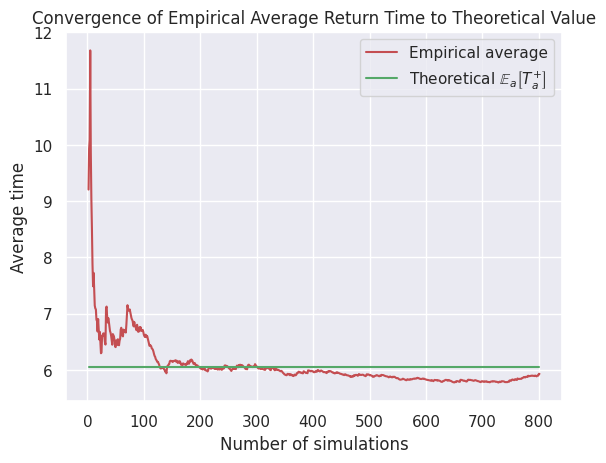

In [ ]:
average_simulations = np.cumsum(times)[1:]/np.arange(2,len(times)+1)
plot_empirical_against_theoretical(average_simulations, n_simulations=800)

# Problem 2
In this part we will again consider the network of Fig. 1, with weights (1). However, now we will simulate many particles moving around in the network in continuous time. Each of the particles in the network will move around just as the single particle moved around in Problem 1: the time it will stay in a node is exponentially distributed, and on average it will stay $\frac{1}{\omega_{i}}$ time-units in a node $i$ before moving to one of its outneighbors. The next node it will visit is based on the probability matrix $P=diag\left(\omega\right)^{-1}\Lambda$, where $\omega=\Lambda\mathbb{1}$.

Your task is to simulate this system from two different perspectives: the *particle perspective*, i.e. "follow the particle", and the *node perspective*, i.e. "observe from the node".

Simulating the system from a particle perspective is exactly as in Problem 1, but here you have to follow many particles instead. To simulate the system from the node perspective you instead have to observe the particles from the node. When doing this you do not have to care about each single particle, but only about the number of particles in the node. Note that at node $i$, each particle in that node will stay there on average $\frac{1}{\omega_{i}}$ time units. Therefore, the node will pass along particles at a rate proportional to the number of particles in the node. In fact, if at time $t$ the number of particles in node $i$ is $n_{i}\left(t\right)$, it will pass along particles at a rate of $n_{i}\left(t\right)\omega_{i}$. The departure times of the node can thus be seen as a Poisson process with rate $n_{i}\left(t\right)\omega_{i}$. At each tick of the Poisson clock of the node, it will move a particle to a neighboring node. The node to which the particle will move is again based on the normalized transition rate matrix $P$.

Simulate the system from the two perspectives, and then answer the following questions (we have again provided a hint below):

## Point a - Particle perspective
* If $N=100$ particles all start in node $a$, what is the average time for a particle to return to node $a$?

This is equivalent to running the function `SingleParticleSimulations` $100$ times

In [ ]:
print("Start node:", V[start_node])

Start node: a


In [ ]:
# N = Number of particles to simulate
N = 100
n_simulations = 10000
return_times_particle_perspective = np.zeros((N, n_simulations))

bar = progressbar.ProgressBar(max_value=N)
for i in range(N):
    simulation_particle = SingleParticleSimulations(Lambda, start_node, n_simulations, use_progressbar=False)
    return_times_particle_perspective[i, :] = [simulation[1][-1] for simulation in simulation_particle]
    bar.update(i+1)
bar.finish()

100% (100 of 100) |######################| Elapsed Time: 0:04:03 Time:  0:04:03


In [ ]:
print("Empirical average time to return in a starting from a:", np.mean(return_times_particle_perspective.mean(axis=1)))

Empirical average time to return in a starting from a: 6.058782815196231


* How does this compare to the answer in Problem 1, why?

**Simulation Results**

* Problem 2 (Particle Perspective with $N\times n\_simulations = 100 \times 10000$): The results were more accurate and closer to the theoretical expectations.

* Problem 1 (Single Particle, `n_simulations = 10000`): There was significant variance in the outcomes.
Comparison:

In Problem 2, the increased sample size inherently reduces the variance in the estimations. By following many particles over numerous simulations, the law of large numbers ensures convergence towards the theoretical values.

Conversely, in Problem 1, the analysis is based on a single particle over
`n_simulations = 10000`. This setup lacks the added accuracy provided by aggregating across multiple particles, resulting in higher variability.

From the particle perspective in Problem 2, simulating $N$ particles for `n_simulations` iterations can be viewed as equivalent to simulating a single particle for $n\times$ `n_simulations` iterations in Problem 1. This is because the behavior of $N$ particles over time effectively samples the system $N$ times more frequently, given the independence of particle movements.
This equivalence explains why the results in Problem 2, with $N\times n\_simulations$ simulations, are closer to the theoretical expectations: the increased sample size reduces statistical variance and improves the accuracy of the estimates.

## Point b - Node perspective
* If $N=100$ particles start in node $a$, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?
* Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time

In [ ]:
# Node perspective using a single, system-wide Poisson clock with rate Nw*
def NodeSimulationSSWPClock(Lambda, x_0, n_particles, time_limit):
    # Compute P_bar from Lambda
    P_bar, w_star = compute_P_bar(Lambda)
    n_states = len(P_bar)

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]
    current_time = 0

    # particles_in nodes[:, t] stores the number of particles in each node
    # at time current_time
    particles_in_nodes = np.zeros((n_states, 1))
    particles_in_nodes[x_0][0] = n_particles

    # No upper bound on the number of steps
    while current_time < time_limit:
        # The random time to wait for the next transition
        # is drawn according to its distribution, as discussed in Remark 1
        # NOTE: in the formula for t_next we use n_particles * w_star, the rate of the "global" Poisson clock
        t_next = np.random.exponential(1/(n_particles * w_star))

        # We need to select which particle to move
        current_n_particles_in_nodes = np.copy(particles_in_nodes[:, -1])
        origin_node = np.random.choice(n_states, p=current_n_particles_in_nodes/np.sum(current_n_particles_in_nodes))
        destination_node = np.random.choice(n_states, p=P_bar[origin_node,:])

        # Update the time because the clock ticked
        current_time += t_next
        transition_times.append(current_time)

        # Move the particle
        current_n_particles_in_nodes[origin_node] -= 1
        current_n_particles_in_nodes[destination_node] += 1
        particles_in_nodes = np.append(particles_in_nodes, current_n_particles_in_nodes.reshape(-1, 1), axis=1)

    return particles_in_nodes, transition_times

In [ ]:
def NodePerspectiveSimulations(Lambda, start_node, n_particles, time_limit, n_simulations, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(NodeSimulationSSWPClock(Lambda, start_node, n_particles, time_limit))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

In [ ]:
def plot_particles_per_node(V, transition_times, particles_in_nodes_history, width=12):
    plt.figure(figsize=(width, 6))
    for i in range(len(V)):
        plt.plot(transition_times, particles_in_nodes_history[i, :], label=f'Node ${V[i]}$')

    plt.xlabel('Time $t$')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.title("Number of particles in each node during the simulation time")
    plt.show()

In [ ]:
simulation_node = NodePerspectiveSimulations(Lambda, start_node, 100, 60, 10000)

100% (10000 of 10000) |##################| Elapsed Time: 1:18:55 Time:  1:18:55


In [ ]:
particles_in_nodes_last_iteration = simulation_node[0][0][:, -1].reshape(-1,1)
for i in range(len(simulation_node)):
    particles_in_nodes_last_iteration = np.append(particles_in_nodes_last_iteration, simulation_node[i][0][:, -1].reshape(-1,1), axis=1)

print("Average number of particles in the different nodes at the end of the simulation:", particles_in_nodes_last_iteration.mean(axis=1))

Average number of particles in the different nodes at the end of the simulation: [23.11908809 16.46455354 27.64653535 18.23307669 14.53674633]


In [ ]:
particles_in_nodes, transition_times = simulation_node[-1]

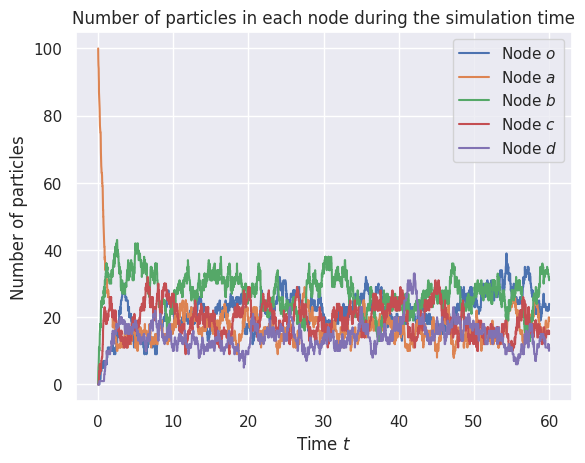

In [ ]:
plot_particles_per_node(V, transition_times, particles_in_nodes)

* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles

The stationary distribution $\bar{\pi}$ obtained from Problem 1 represents the long-term proportion of time a single particle spends in each node. It is given by:
$$\bar{\pi}=\begin{pmatrix}
0.23058252 & 0.16504854 & 0.27669903 & 0.18203883 & 0.14563107  \\
\end{pmatrix}'$$
In problem 2, we simulated 100 particles moving in the network and measured the average number of particles in each node at the end of the simulation. The observed particle distribution was: $$\widehat{\pi}=\frac{1}{100}\begin{pmatrix}
23.11908809 & 16.46455354 & 27.64653535 & 18.23307669 & 14.53674633  \\
\end{pmatrix}'$$
Comparing $\bar{\pi}$ and $\widehat{\pi}$, we observe that the values are nearly identical, with differences on the order of $10^{-4}$. This confirms that the simulated multi-particle system follows the same stationary distribution as a single particle in continuous-time random walk theory. The small discrepancies arise due to finite sampling effects, and they would diminish further with a larger number of particles or a longer simulation time.

# Problem 3
In this part we consider the open network of Figure 2, with transition rate matrix $\Lambda_{open}$ according to $(2)$.

$\Lambda_{open} =
\begin{pmatrix}
0 & \frac{3}{4} & \frac{3}{4} & 0 & 0 \\
0 & 0 & \frac{1}{4} & \frac{1}{4} & \frac{2}{4} \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$ $(2)$

<figure>
    <img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H2/sources/G2.png"/>
    <figcaption>Figure 2: Open network</figcaption>
</figure>
For this system, particles will enter the system at node $o$ according to a Poisson process with input rate $\lambda$. Each node will then pass along a particle according to a given rate, similar to what you did in Problem 2 with the "node perspective". Let $\omega=\Lambda\mathbb{1}$ and let $N\left(t\right)$ denote the vector of number of particles in each node at time $t$.

You will simulate two different scenarios that differ by what rate the nodes will pass along particles:

1. Proportional rate: Each node $i$ will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node $i$, i.e., the node $i$ will pass along particles rate with rate $\omega_{i}N_{i}\left(t\right)$
2. Fixed rate: Each node $i$ will instead pass along particles with a fixed rate $\omega_{i}$.

Since node $d$ does not have a node to send its particles to, we assume that $\omega_{d}=2$. When the Poisson clock of node $d$ ticks, you could simply decrease the number of particles in the node by one (If there are any particles in the node). Equivalently think of another node $d'$ connected to node $d$, such that at every tick of the Poisson clock of $d$, it sends a particle to node $d'$.

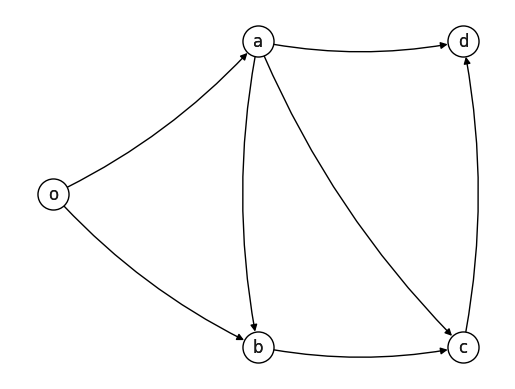

In [ ]:
#defining and printing the given graph
V = ['o', 'a', 'b', 'c', 'd']
E = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('a', 'd'), ('b','c'),
     ('c','d')]

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)
nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [ ]:
# Defining Lambda
Lambda = np.array([
     [0, 3/4, 3/4, 0, 0],
     [0, 0, 1/4, 1/4, 2/4],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0]
])

The goal is to simulate the two systems and answer the following questions:

## Point a - Proportional rate
* Simulate the system for $60$ time units and plot the evolution of the number of particles in each node over time with input rate $\lambda=100$.

In [ ]:
5 if 7>5 else 2

5

In [ ]:
def PoissonProcessRate(w_i, N_i, fixed_rate):
    return w_i if fixed_rate else w_i * N_i

def ProportionalRateNodePerspective(Lambda, x_0, x_n, input_rate, time_limit, fixed_rate = False):
    # Compute P_bar from Lambda
    P_bar, _ = compute_P_bar(Lambda)
    n_states = len(P_bar)
    w = Lambda.dot(np.ones((n_states, 1))).reshape(-1)
    w[x_n] = 2

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]
    current_time = 0

    # clocks of each node
    clocks = np.zeros(n_states)

    # particles_in nodes[:, t] stores the number of particles in each node
    # at time current_time
    particles_in_nodes = np.zeros((n_states, 1))

    bar = progressbar.ProgressBar(max_value=time_limit)
    i = 0
    # No upper bound on the number of steps
    while current_time < time_limit:
        current_n_particles_in_nodes = np.copy(particles_in_nodes[:, -1])

        # The random time to wait the first input time
        t_input = np.random.exponential(1/input_rate)

        # Are there particles in the graph? Because we cannot
        # make transitions if there are not particles
        clocks[:] = [np.random.exponential(1/PoissonProcessRate(w[i], particles_in_nodes[i, -1], fixed_rate)) if particles_in_nodes[i, -1] != 0 else t_input + 1 for i in range(n_states)]

        # First clock in doing tick
        first_clock_tick = clocks.argmin()
        t_transition = clocks[first_clock_tick]

        #if t_input>t_transition:
        #   print(i, "t_input:", t_input, "with rate parameter", input_rate)
        #   print("First clock doing tick:", first_clock_tick, "with t_transition:", t_transition,"and rate parameter", w[first_clock_tick] * particles_in_nodes[first_clock_tick, -1], "\n"*2)


        # Input clock ticks first
        if t_input < t_transition:
            t_next = t_input
            # Add a new particle in x_0
            current_n_particles_in_nodes[x_0] += 1

        # Transition clock ticks first
        elif first_clock_tick == x_n:
            t_next = clocks[x_n]
            # Node x_n is a sink, remove the particle
            current_n_particles_in_nodes[first_clock_tick] -= 1

        else:
            t_next = clocks[first_clock_tick]
            destination_node = np.random.choice(n_states, p=P_bar[first_clock_tick,:])

            # Move the particle
            current_n_particles_in_nodes[first_clock_tick] -= 1
            current_n_particles_in_nodes[destination_node] += 1

        # Update the time because the clock ticked
        current_time += t_next
        transition_times.append(current_time)
        particles_in_nodes = np.append(particles_in_nodes, current_n_particles_in_nodes.reshape(-1, 1), axis=1)

        if current_time <= time_limit:
            bar.update(current_time)

    bar.finish()

    return particles_in_nodes, transition_times

In [ ]:
start_node = V.index('o')
end_node = V.index('d')

100% (60 of 60) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


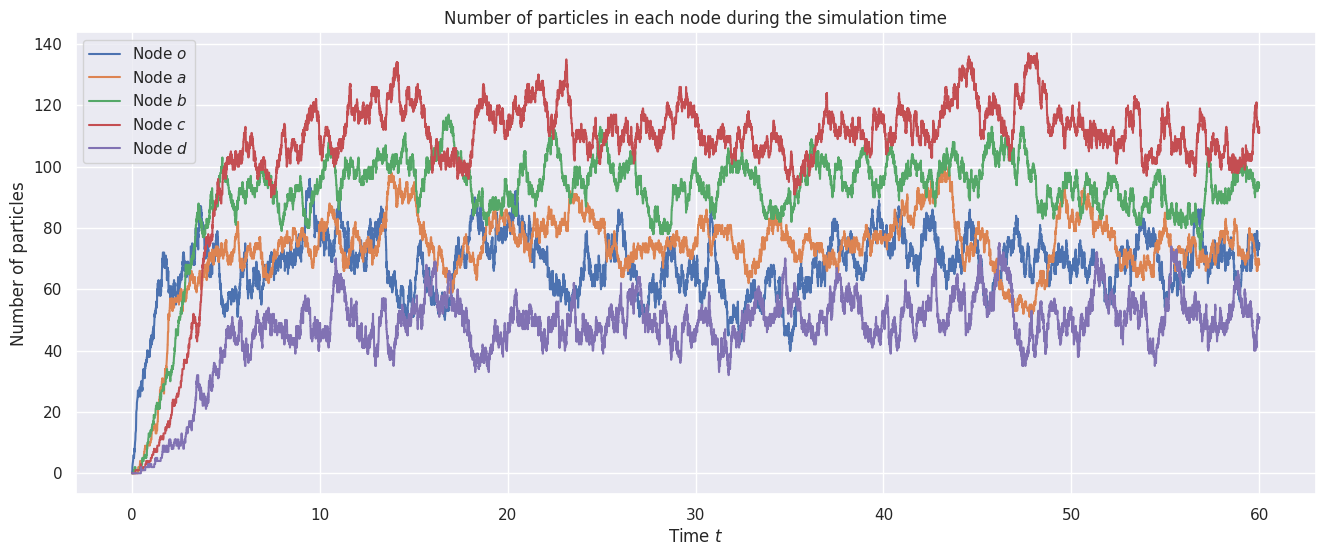

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 100, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

* What is the largest input rate that the system can handle without blowing up?

100% (60 of 60) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


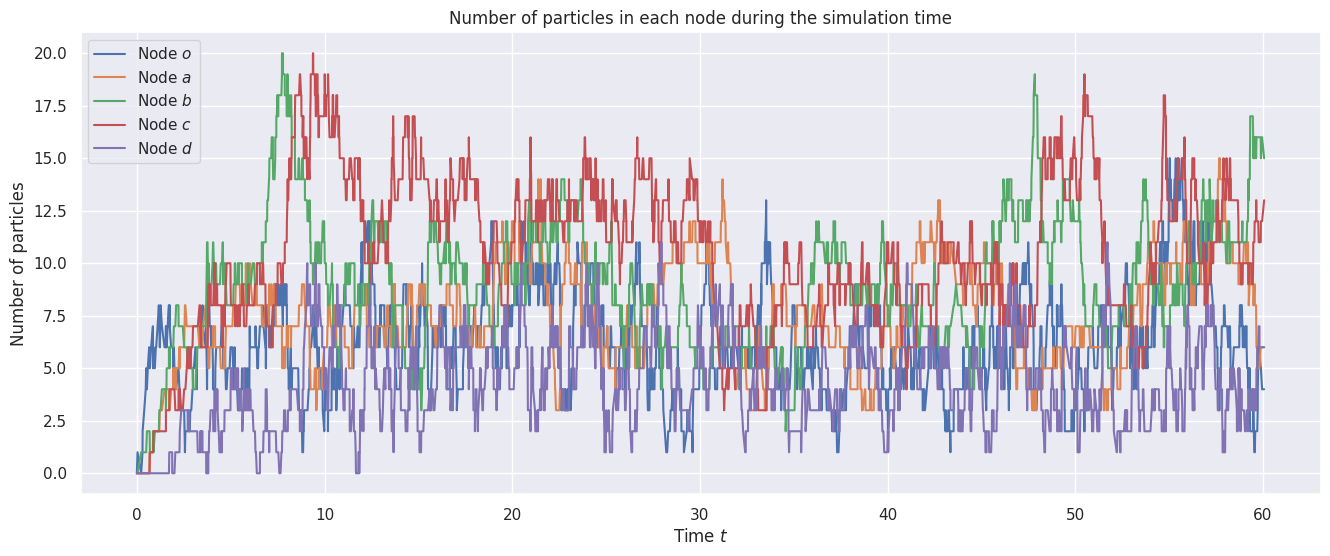

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 10, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

100% (60 of 60) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


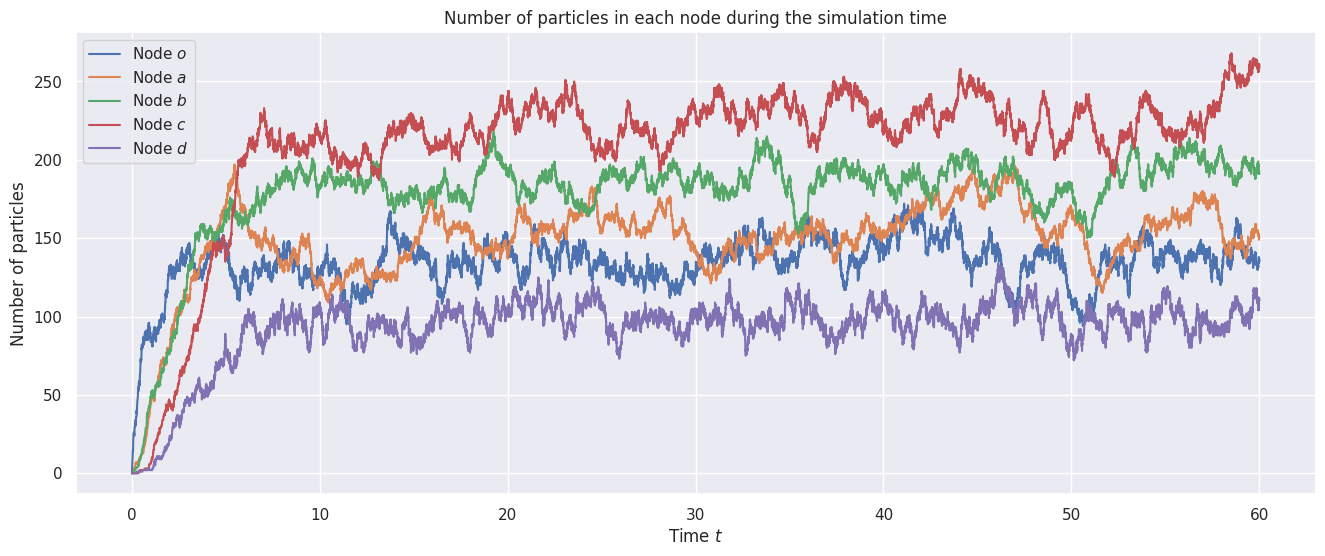

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 200, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

| |   #                                          | 147063 Elapsed Time: 0:01:13


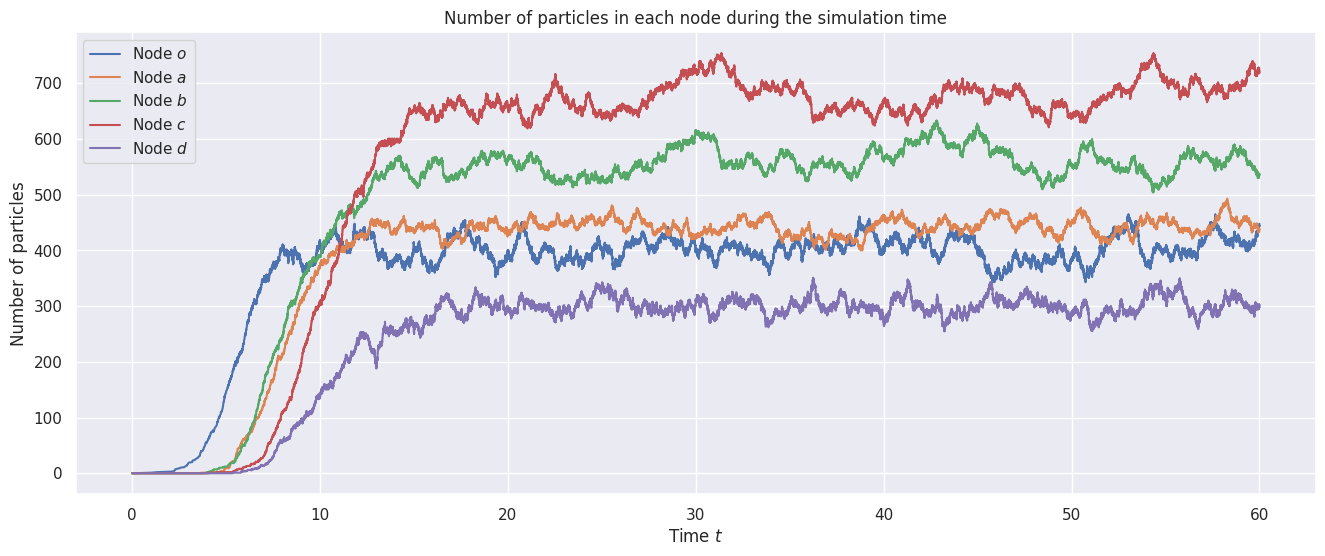

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 600, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

| |                                     #        | 476117 Elapsed Time: 0:18:20


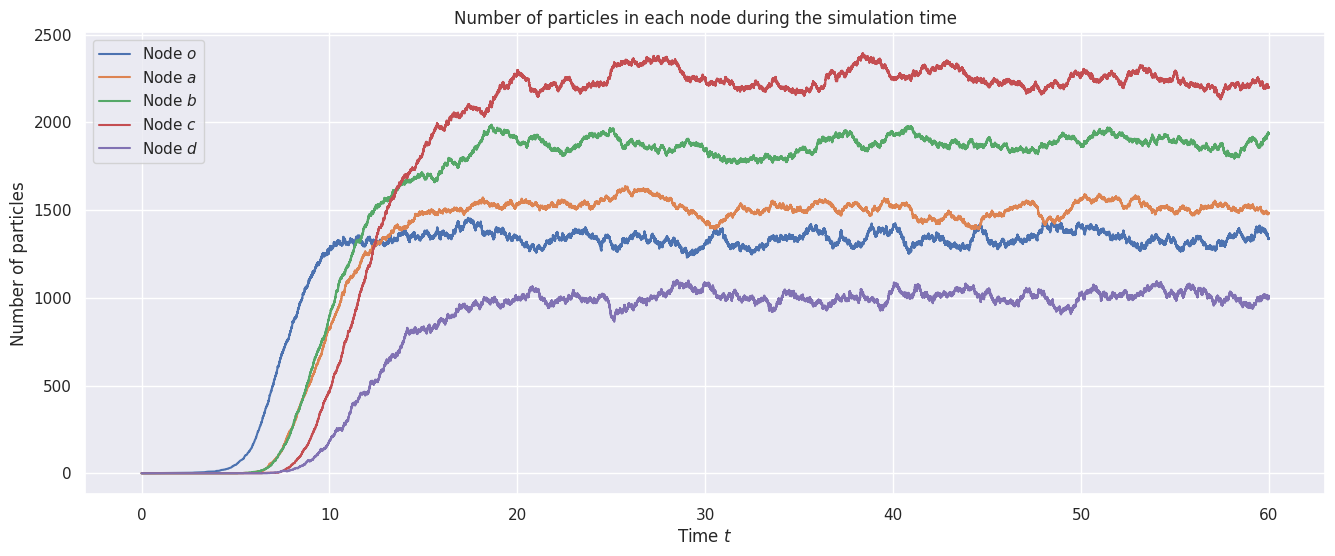

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 2000, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

## Point b - Fixed rate
* Simulate the system for $60$ time units and plot the evolution of the number of particles in each node over time with input rate $\lambda=1$.

100% (60 of 60) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


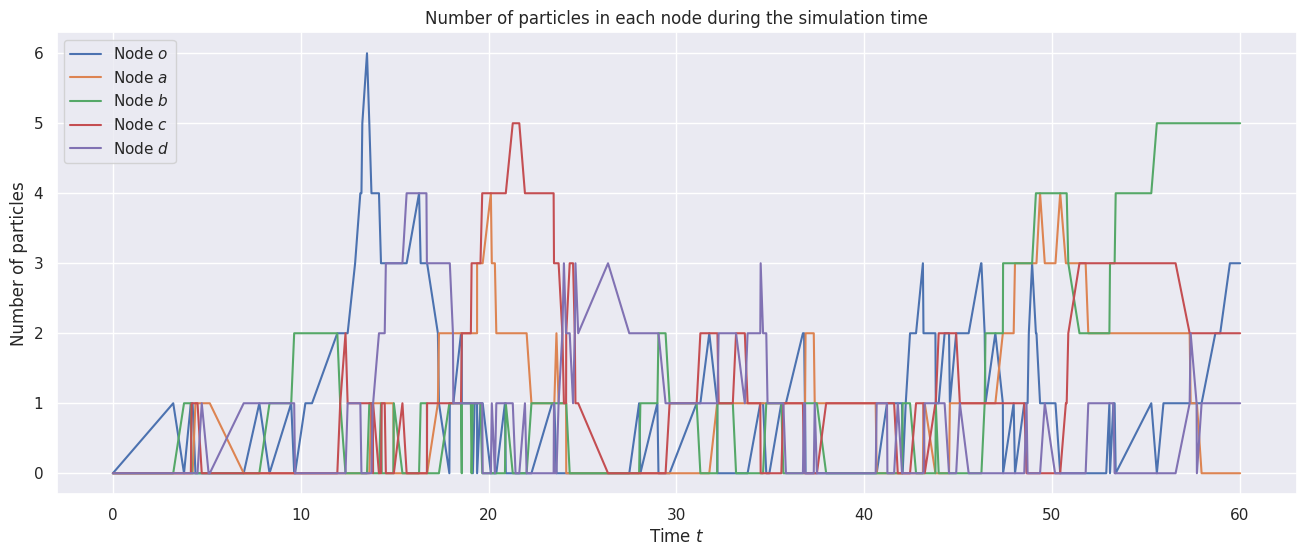

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 1, 60, fixed_rate=True)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

* What is the largest input rate that the system can handle without blowing up? Motivate your answer

100% (60 of 60) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


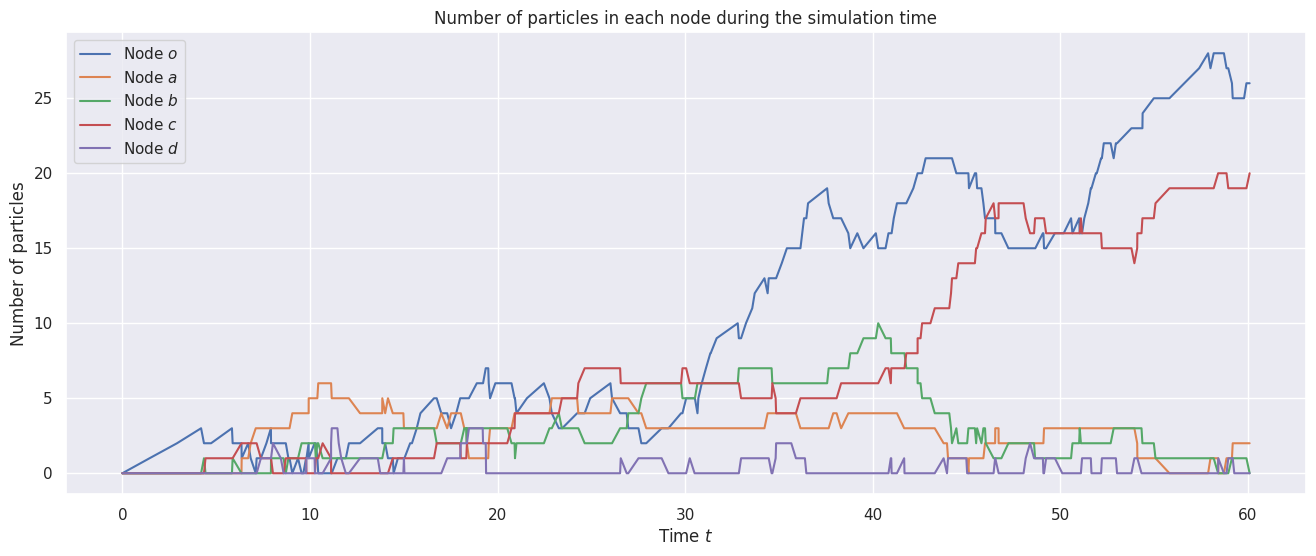

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 1.865, 60, fixed_rate=True)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)